In [1]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.feature_selection import RFE, VarianceThreshold, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from functools import partial

import xgboost as xgb

### Preprocessing the Data for Machine Learning Models

1. **Data Encoding:**
   - Encode categorical variables into numerical representations using techniques like one-hot encoding or label encoding.

2. **Normalization and Scaling:**
   - Normalize or scale numerical features to ensure uniformity and improve model performance.
   - Techniques include Min-Max scaling or Standardization.

3. **Feature Selection Methods**
    - Techniques include: filter, wrapper, and embedded methods.

4. **Data Splitting:**
   - Split the dataset into training and testing sets for machine learning models.

In [2]:
# Read ML file
file_path = './data/vax_trials_ml_df.csv'
df_ml = pd.read_csv(file_path)

# Display the DataFrame
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000


- Data encoding: 

    - phase
    - gender
    - agency_class
    - country


In [3]:
# Define mapping for phase categories to numerical values
phase_mapping = {
    'Early Phase 1': 1,
    'Phase 1': 2,
    'Phase 1/Phase 2': 3,
    'Phase 2': 4,
    'Phase 2/Phase 3': 5,
    'Phase 3': 6,
    'Phase 4': 7,
    'Not Applicable': 0
}

# Map the 'phase' column to numerical values
df_ml['phase_encoded'] = df_ml['phase'].map(phase_mapping)

# Display df
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4


In [4]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'gender' column
df_ml['gender_encoded'] = le.fit_transform(df_ml['gender'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0


In [5]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'agency_class' column
df_ml['agency_class_encoded'] = le.fit_transform(df_ml['agency_class'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,...,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,...,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,...,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,...,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,...,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,...,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


In [6]:
# Drop 'phase','gender', angency_class columns
df_ml = df_ml.drop(['phase', 'gender', 'agency_class'], axis=1)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,country,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,450.0,infectious diseases,12.0,saudi arabia,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,NCT00623831,17.0,cancer,60.0,germany,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,NCT00434577,715.0,infectious diseases,7.0,multiple,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,NCT00616421,2907.0,infectious diseases,13.0,multiple,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,NCT04515147,668.0,infectious diseases,17.0,multiple,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


In [7]:
# Encode the 'country' column
df_ml = BinaryEncoder(cols=['country']).fit(df_ml).transform(df_ml)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,country_0,country_1,country_2,country_3,country_4,country_5,...,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,450.0,infectious diseases,12.0,0,0,0,0,0,1,...,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,NCT00623831,17.0,cancer,60.0,0,0,0,0,1,0,...,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,NCT00434577,715.0,infectious diseases,7.0,0,0,0,0,1,1,...,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,NCT00616421,2907.0,infectious diseases,13.0,0,0,0,0,1,1,...,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,NCT04515147,668.0,infectious diseases,17.0,0,0,0,0,1,1,...,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


#### Feature selection methods

Filter methods

- Variance threshold: to remove any features that have little to no variation in their values.
- Pearson’s correlation: measuring the linear relationship between two numeric, continuous variables. Correlation between features, and correlation between features and target.
- F-statistic: correlation between features and target.
- Mutual information: measures the dependence between two variables and can be used to estimate how much a feature contributes to the prediction of the target variable.

In [8]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5',
                       'phase_encoded', 'gender_encoded', 'agency_class_encoded', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

In [9]:
# Variance threshold
selector = VarianceThreshold(threshold=0)  # 0 is default
print(selector.fit_transform(features))

[[4.50000000e+02 1.20000000e+01 1.75000000e+01 ... 2.40444444e+00
  9.88888889e-01 6.81333333e+00]
 [1.70000000e+01 6.00000000e+01 4.15000000e+01 ... 5.88235294e+00
  3.00000000e+00 6.70000000e+01]
 [7.15000000e+02 7.00000000e+00 3.38993661e+01 ... 2.40000000e+00
  2.03714685e+02 6.99020979e+00]
 ...
 [3.00000000e+02 7.00000000e+00 3.35000000e+01 ... 1.40000000e-01
  3.00000000e+00 1.30000000e+01]
 [1.44700000e+03 1.20000000e+01 1.70000000e+01 ... 3.93849343e+00
  6.60000000e+01 1.09723566e+01]
 [4.80000000e+01 3.00000000e+00 3.38993661e+01 ... 5.16666667e+00
  6.00000000e+00 7.79166667e+01]]


In [10]:
# Use indices to get the corresponding column names of selected features
num_cols = list(features.columns[selector.get_support(indices=True)])
print(num_cols)

['enrollment', 'actual_duration', 'mean_age_imp', 'AE_total_serious', 'AE_total_other', 'subjects_at_risk_serious', 'subjects_at_risk_other', 'AE_serious_freq', 'AE_other_freq', 'subjects_at_risk_serious_freq', 'subjects_at_risk_other_freq']


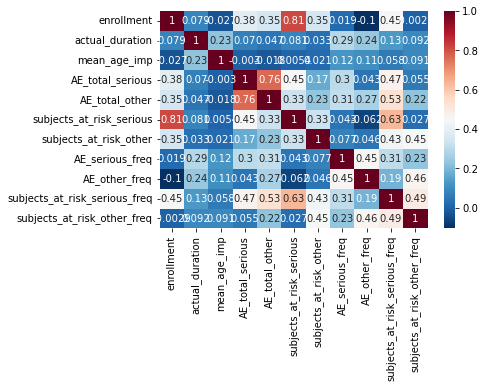

In [11]:
# Pearson’s correlation: 
# Correlation between features: drop highly correlated features to avoid duplicate information.

corr_matrix = features.corr(method='pearson') 

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [12]:
# Correlation between features and target

X_y = features.copy()
X_y['dropout_rate'] = target

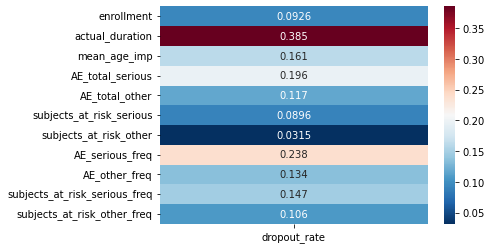

In [13]:
corr_matrix = X_y.corr()

# Isolate the column corresponding to 'dropout'
corr_target = corr_matrix[['dropout_rate']].drop(labels=['dropout_rate'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [14]:
# F-statistic: correlation between features and target
# The F-statistic will be larger (and p-value will be smaller) for predictors that are more highly correlated with the target variable
# First array: F-statistic
# Second array: p-value

print(f_regression(features, target))

(array([  8.60312975, 173.27695458,  26.48230427,  39.90765647,
        13.70198793,   8.04566117,   0.98801421,  59.74816589,
        18.25417154,  22.04145067,  11.3934159 ]), array([3.43280514e-03, 1.34213986e-36, 3.20359371e-07, 4.00889249e-10,
       2.25984124e-04, 4.65381495e-03, 3.20469863e-01, 2.62919313e-14,
       2.11851018e-05, 3.04192301e-06, 7.65532421e-04]))


In [15]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5','dropout_rate'], axis=1)
features.head()

,enrollment,actual_duration,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,450.0,12.0,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,17.0,60.0,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,715.0,7.0,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,2907.0,13.0,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,668.0,17.0,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


In [16]:
# Mutual information

# features
features = df_ml.drop(['nct_id', 'condition_name', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

print(mutual_info_regression(features, target, discrete_features=[11,12,13], random_state=68))

[0.20694377 0.17851112 0.         0.00293911 0.         0.00314686
 0.04147552 0.03534199 0.03800043 0.09850034 0.08192192 0.
 0.01960093 0.01041031 0.         0.11520945 0.02147017 0.02154608
 0.03592117 0.03863665]


In [17]:
score_func = partial(mutual_info_regression, discrete_features=[11,12,13], random_state=68)

# Select top 5 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=5)

print(selection.fit_transform(features, target))

[[4.50000000e+02 1.20000000e+01 1.00000000e+00 1.08200000e+03
  9.88888889e-01]
 [1.70000000e+01 6.00000000e+01 3.00000000e+00 1.00000000e+02
  3.00000000e+00]
 [7.15000000e+02 7.00000000e+00 3.49000000e+02 1.71600000e+03
  2.03714685e+02]
 ...
 [3.00000000e+02 7.00000000e+00 3.00000000e+00 4.20000000e+01
  3.00000000e+00]
 [1.44700000e+03 1.20000000e+01 9.30000000e+01 5.69900000e+03
  6.60000000e+01]
 [4.80000000e+01 3.00000000e+00 6.00000000e+00 2.48000000e+02
  6.00000000e+00]]


In [18]:
X = features[features.columns[selection.get_support(indices=True)]]
print(X)

     enrollment  actual_duration  AE_total_serious  AE_total_other  \
0         450.0             12.0               1.0          1082.0   
1          17.0             60.0               3.0           100.0   
2         715.0              7.0             349.0          1716.0   
3        2907.0             13.0             119.0          4625.0   
4         668.0             17.0             140.0          3398.0   
..          ...              ...               ...             ...   
992       406.0             19.0               0.0           169.0   
993        50.0             56.0              38.0           123.0   
994       300.0              7.0               3.0            42.0   
995      1447.0             12.0              93.0          5699.0   
996        48.0              3.0               6.0           248.0   

     subjects_at_risk_serious_freq  
0                         0.988889  
1                         3.000000  
2                       203.714685  
3          

One-Hot Encoding:

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.
- disadvantage: it can lead to a high-dimensional feature space if there are many unique diseases, so it may not be efficient for large datasets.

In [19]:
# Create dummy variables for 'condition_name' 
df_ml = pd.get_dummies(df_ml, columns=['condition_name'], prefix=['condition'])
df_ml.head()

,nct_id,enrollment,actual_duration,country_0,country_1,country_2,country_3,country_4,country_5,dropout_rate,...,condition_cancer,condition_chronic diseases,condition_congenital disorders,condition_healthy,condition_heart diseases,condition_infectious diseases,condition_inflammatory diseases,condition_pregnancy,condition_respiratory disorders,condition_transplant
0,NCT00444951,450.0,12.0,0,0,0,0,0,1,3.111111,...,0,0,0,0,0,1,0,0,0,0
1,NCT00623831,17.0,60.0,0,0,0,0,1,0,11.764706,...,1,0,0,0,0,0,0,0,0,0
2,NCT00434577,715.0,7.0,0,0,0,0,1,1,1.818182,...,0,0,0,0,0,1,0,0,0,0
3,NCT00616421,2907.0,13.0,0,0,0,0,1,1,3.611971,...,0,0,0,0,0,1,0,0,0,0
4,NCT04515147,668.0,17.0,0,0,0,0,1,1,8.532934,...,0,0,0,0,0,1,0,0,0,0


#### Recursive Feature Elimination

In [20]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate'], axis=1)
y = df_ml['dropout_rate']

In [21]:
# Get feature names
features = x.columns

# Create a linear regression model
lm = LinearRegression()

# Standardize the data
x = pd.DataFrame(StandardScaler().fit_transform(x))

# Create a recursive feature elimination model
rfe = RFE(estimator=lm, n_features_to_select=6)

# Fit the recursive feature elimination model to x and y
rfe.fit(x, y)

# Print the model accuracy after doing recursive feature elimination
print(rfe.score(x, y))

# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

0.2373339954499002
['actual_duration', 'AE_total_serious', 'subjects_at_risk_serious', 'subjects_at_risk_serious_freq', 'condition_autoimmune diseases', 'condition_cancer']


In [22]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate'], axis=1)
y = df_ml['dropout_rate']

In [23]:
# Get feature names
features = x.columns

# Create a random forest regression model
rfr = RandomForestRegressor()

# Create a recursive feature elimination model
rfe = RFE(estimator=rfr, n_features_to_select=6)

# Fit the recursive feature elimination model to x and y
rfe.fit(x, y)

# Print the model accuracy after doing recursive feature elimination
print(rfe.score(x, y))

# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

0.8863810282659199
['enrollment', 'actual_duration', 'AE_total_other', 'AE_serious_freq', 'AE_other_freq', 'subjects_at_risk_other_freq']


#### Select Variables

The data for the model will consist of a subset of variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, denoted by the 'dropout_rate', indicating the percentage of dropouts per clinical trial.

In [24]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate', 'AE_total_serious', 'AE_serious_freq', 'AE_other_freq', 'subjects_at_risk_serious', 'subjects_at_risk_other'], axis=1)
y = df_ml['dropout_rate']

In [25]:
# Select variables and standardize the data
features = df_ml.drop(['nct_id', 'dropout_rate', 'AE_total_serious', 'AE_serious_freq', 'AE_other_freq', 'subjects_at_risk_serious', 'subjects_at_risk_other'], axis=1)
standard_scaler = StandardScaler().fit(x)
x_scaled = standard_scaler.transform(features)

#### Splitting the Data

Next, the data needs to be divided into training and validation sets. In this split, 20% of the data is reserved for final validation, while 80% is allocated for training the model.

In [26]:
# Splitting the data

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 42)

#Split the scaled data into chunks
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y, test_size=val_size, random_state = 42)


#### Prediction

- **Model Building:** for this project, five algorithms will be used to make predictions:

  1. Linear Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests
  5. XGBoost

- **Evaluation Metrics:**
  - Mean Squared Error (MSE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Error (MAE)
  - R-squared (R2)

##### Multiple Linear Regression

In [27]:
# Initialize and train a linear regression model
lm = LinearRegression()
lm.fit(x_train_scaled, y_train_scaled)

# Make predictions on the test set
y_pred = lm.predict(x_test_scaled)

In [28]:
# Print coeficients and intercept
print("Coefficients of each feature:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficients of each feature: [ 1.00287463e+00  2.36299712e+00 -6.65715577e-02 -3.31940905e-02
 -4.81024653e-01 -7.98024626e-03 -1.51994147e+00  1.59523897e+00
  5.38216746e-02  1.85573496e+00  7.58228717e-01  7.32948295e-01
 -3.04945882e-01  4.99059230e-01  1.87929195e-01  9.79371885e+11
  2.28641939e+12  6.91196835e+12  1.19887779e+12  6.92868414e+11
  2.83373081e+12  6.92868414e+11  8.07461528e+12  1.82762761e+12
  6.92868414e+11  1.54618670e+12  9.79371885e+11]
Intercept: 8.971334150859374


In [29]:
#Print train and test score
print("Train score:")
print(lm.score(x_train_scaled, y_train_scaled))

print("Test score:")
print(lm.score(x_test_scaled, y_test_scaled))

Train score:
0.22123523966339076
Test score:
0.2602787066623018


In [30]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test_scaled, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test_scaled, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test_scaled, y_pred)
print("R-squared:", r2)

Mean Squared Error: 194.8863876297697
Root Mean Squared Error: 13.9601714756578
Mean Absolute Error: 7.768943162637881
R-squared: 0.2602787066623018


L1 and L2 Regularization

In [31]:
# Initialize and fit the Lasso (L1) regularized regression model
lasso = Lasso(alpha = 0.05)
lasso.fit(x_train_scaled, y_train_scaled)

# Make predictions on the test data
y_pred = lasso.predict(x_test_scaled)

#Print train and test R2 score
print("Train score:")
print(lasso.score(x_train_scaled, y_train_scaled))

print("Test score:")
print(lasso.score(x_test_scaled, y_test_scaled))

# Calculate the evaluation metrics to assess the model's performance
mse = mean_squared_error(y_test_scaled, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test_scaled, y_pred)
print("Mean Absolute Error:", mae)

Train score:
0.22095871542209855
Test score:
0.26162824740652324
Mean Squared Error: 194.5308386913124
Root Mean Squared Error: 13.947431257809175
Mean Absolute Error: 7.7518159638134145


In [32]:
# Initialize and fit the Ridge (L2) regularized regression model
ridge = Ridge(alpha = 0.05)
ridge.fit(x_train_scaled, y_train_scaled)

# Make predictions on the test data
y_pred = ridge.predict(x_test_scaled)

#Print train and test R2 score
print("Train score:")
print(ridge.score(x_train_scaled, y_train_scaled))

print("Test score:")
print(ridge.score(x_test_scaled, y_test_scaled))

# Calculate the evaluation metrics to assess the model's performance
mse = mean_squared_error(y_test_scaled, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test_scaled, y_pred)
print("Mean Absolute Error:", mae)

Train score:
0.2212374701014913
Test score:
0.2602425980080352
Mean Squared Error: 194.89590078730023
Root Mean Squared Error: 13.960512196452544
Mean Absolute Error: 7.769519658219935


##### K Nearest Neighbor

In [33]:
# Initialize the KNN regressor 
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the KNN regressor on the training data
knn_regressor.fit(x_train_scaled, y_train_scaled)

# Make predictions on the test data
y_pred = knn_regressor.predict(x_test_scaled)

In [34]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test_scaled, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test_scaled, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test_scaled, y_pred)
print("R-squared:", r2)

Mean Squared Error: 196.10709274894813
Root Mean Squared Error: 14.003824218724974
Mean Absolute Error: 8.00607847642013
R-squared: 0.2556453324152609


Hyperparameter tuning

In [35]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],   # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski metric
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train_scaled, y_train_scaled)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test_scaled, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test_scaled, y_pred)
print("R-squared:", r2)

Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Mean Squared Error: 196.7768765896975
Mean Absolute Error: 7.691023331196816
R-squared: 0.25310306471272115


##### Decision Trees

In [36]:
# Initialize the Decision Tree
dt = DecisionTreeRegressor(max_depth=3)

# Train the Decision Tree on the training data
dt.fit(x_train, y_train)

# Make predictions on the test data
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.3164474610596848


Hyperparameter tuning

In [37]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'max_depth': 3, 'min_samples_split': 2}
Mean Squared Error: 180.0882119644758
Root Mean Squared Error: 13.41969492814482
Mean Absolute Error: 7.397378774978515
R-squared: 0.3164474610596846


In [38]:
# # Plot tree
# plt.figure(figsize=(10,10))
# tree.plot_tree(dt, feature_names = x_train.columns,  
#               filled=True)

##### Random Forests

In [39]:
rfr = RandomForestRegressor(max_depth=7)
rfr.fit(x_train, y_train)
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)


# Print R-squared scores on training and test data
print(f'Train set R-squared: {r_squared_train}')
print(f'Test set R-squared: {r_squared_test}')

# Print Mean Absolute Error on training and test data
avg_dropout = y.mean()
print(f'Avg dropout rates Train/Test: {avg_dropout}')

y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train set MAE: {mae_train}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test set MAE: {mae_test}')

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (test):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (test):", rmse)

Train set R^2: 0.6888570041884139
Test set R^2: 0.4759328068206907
Avg dropout rates Train/Test: 9.152207957266722
Train set MAE: 5.227393846836045
Test set MAE: 6.92261106896128
Mean Squared Error (test): 180.0882119644758
Root Mean Squared Error (test): 13.41969492814482


Hyperparameter tuning

In [43]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 9],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] # The function to measure the quality of a split.
}


# Instantiate GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Best parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 10}
Mean Squared Error: 163.26576046521484
Mean Absolute Error: 7.30549607000753
R-squared: 0.38029966608789834
Root Mean Squared Error: 12.777549078959346


XGBoost
- Hyperparameter tuning

In [45]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7], # Maximum depth of a tree.
    'learning_rate': [0.01, 0.1, 0.3], # Step size shrinkage used in update to prevents overfitting. 
    'n_estimators': [100, 150, 200], # The number of trees in the boosting algorithm.
    'subsample': [0.5, 0.7, 0.9], # Subsample ratio of the training instances. 
    'colsample_bytree': [0.5, 0.7, 0.9] # Subsample ratio of columns when constructing each tree.
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Mean Squared Error: 162.4926334386484
Mean Absolute Error: 7.283783829798881
R-squared: 0.38323418876524673
Root Mean Squared Error: 12.747259840398971
